In [2]:
using DMRJtensor
include("su2_tools.jl");


In [157]:
# setup system with isotropic J
spinmag = 0.5;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag)
Ns = 20 # number of sites

J_tensors = []
push!(J_tensors,[0.0, 1.0, 0.0])
#push!(J_tensors,[ [2.0, 0.2, 0.0], [0.0, 2.0, 0.0], [0.0, 0.0, 2.0] ])
H_onesite, H_op_vec = H_SU2_Jtensor(spinmag, J_tensors) # make the onsite term

H_mpo = makeMPO(H_onesite,size(Id,1),Ns); # make the MPO!
psi0 = makePsi0(spinmag,Ns);
psi = copy(psi0)
println(psi[1])

printing regular tensor of type: tens{Complex{Float64}}
size = (1, 2, 1)
T = Complex{Float64}[0.8974180251304189 + 0.3774060623290856im, 0.1565277722819889 + 0.6365381388746467im]



In [158]:
nOps = length(H_op_vec)
MPO_op_vec = []
for idx = 1:nOps
    MPO_here = makeMPO(H_op_vec[idx],size(Id,1),Ns);
    push!(MPO_op_vec, MPO_here)
end


In [159]:
# DMRG sweeps, with refinement 

nsweeps_m10 = 20
nsweeps_m40 = 10
nsweeps_m80 = 5

for i in 1:nsweeps_m10
    @time dmrg(psi, H_mpo, maxm = 10, cutoff = 1E-4)
end
println("coarse run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

for i in 1:nsweeps_m40
    @time dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-8)
end
println("intermediate run completed")
#for i in 1:nsweeps_m80
#    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
#end
#println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

  0.012960 seconds (36.05 k allocations: 2.271 MiB)
  0.012293 seconds (32.07 k allocations: 2.255 MiB)
  0.008084 seconds (32.07 k allocations: 2.255 MiB)
  0.007254 seconds (32.07 k allocations: 2.255 MiB)
  0.006558 seconds (32.07 k allocations: 2.255 MiB)
  0.009951 seconds (32.07 k allocations: 2.255 MiB)
  0.006557 seconds (32.07 k allocations: 2.255 MiB)
  0.006554 seconds (32.07 k allocations: 2.255 MiB)
  0.006421 seconds (32.07 k allocations: 2.255 MiB)
  0.006642 seconds (32.07 k allocations: 2.255 MiB)
  0.009555 seconds (32.07 k allocations: 2.255 MiB)
  0.010400 seconds (32.07 k allocations: 2.255 MiB)
  0.006640 seconds (32.07 k allocations: 2.255 MiB)
  0.009888 seconds (32.07 k allocations: 2.255 MiB)
  0.008576 seconds (32.07 k allocations: 2.255 MiB)
  0.009369 seconds (32.07 k allocations: 2.255 MiB)
  0.007405 seconds (32.07 k allocations: 2.255 MiB)
  0.009414 seconds (32.07 k allocations: 2.255 MiB)
  0.006668 seconds (32.07 k allocations: 2.255 MiB)
  0.017221 s

In [164]:
# evaluate Correlation matrix

corMat = zeros(ComplexF64,nOps,nOps)

op_expect = zeros(ComplexF64,nOps)

for idx = 1:nOps
    op_expect[idx] = expect(psi,MPO_op_vec[idx])
end

for idx1 = 1:nOps
    for idx2 = 1:nOps
        val_h = 0.5*expect(psi,MPO_op_vec[idx1],MPO_op_vec[idx2])
        val_h += 0.5*expect(psi,MPO_op_vec[idx2],MPO_op_vec[idx1])
        val_h += -(op_expect[idx1]*op_expect[idx2])
        corMat[idx1,idx2] = val_h
    end
end
broadcast(real,corMat)

3×3 Array{Float64,2}:
 1.1875       7.4539e-17   1.1875    
 7.4539e-17  -1.42109e-14  7.4539e-17
 1.1875       7.4539e-17   1.1875    

In [161]:
maximum(broadcast(abs,corMat - corMat'))
MPO_op_vec[3][2][3,:,:,2]

tens{Complex{Float64}}((2, 2), Complex{Float64}[0.5 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -0.5 + 0.0im])

In [162]:
using LinearAlgebra
using Printf

#keep_idx = [1,2,3,4,8,12] # S_i and (S_ii)^2 operators only
keep_idx = 1:3 # all operators
corMat_reduced = corMat[keep_idx,keep_idx]

vals,vecs = LinearAlgebra.eigen(corMat_reduced)
min_val, tar_idx = findmin(broadcast(abs,vals))
#min_val, tar_idx = findmin(broadcast(real,vals))

op_estimate = broadcast(abs,vecs[:,tar_idx])/maximum(broadcast(abs,vecs[:,tar_idx]))

@printf("eigenvalues = ")
for val in vals
    @printf("%.5f ",real(val))
end
@printf("\n")

@printf("min_eig = %E \n",min_val)

@printf("operators = ")
for op in op_estimate
    @printf("%.5f ",op)
end
@printf("\n")

J_tensors[1]

eigenvalues = -0.00000 -0.00000 2.37500 
min_eig = 3.140188E-16 
operators = 1.00000 0.00000 1.00000 


3-element Array{Float64,1}:
 0.0
 1.0
 0.0

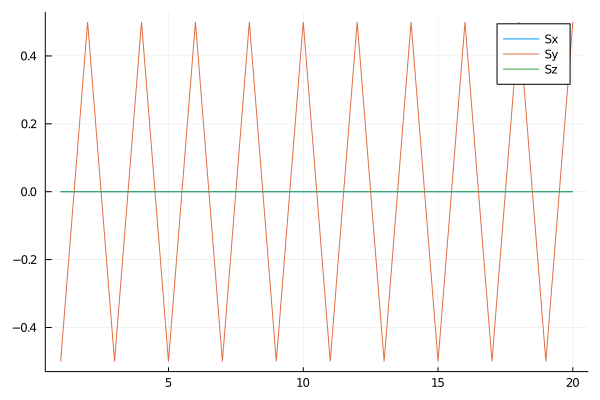

In [163]:
# Evaluate and plot the site-dependent magnetization
S_vals = zeros(ComplexF64,Ns,3)
S_ops = [Sx, Sy, Sz]

S0 = [Id O 
      O Id]
S0_mpo = Array{Array{ComplexF64,2},1}(undef,Ns)

for site = 1:Ns
   S0_mpo[site] = S0
end

for site = 1:Ns
    for op_idx = 1:3
        Sop_here = copy(S0_mpo)
        Sop_here[site] = [Id            O
                          S_ops[op_idx] Id]
        mpo_h = makeMPO(Sop_here,size(Id,1),Ns)
        S_vals[site,op_idx] = expect(psi,mpo_h)
    end
end

using Plots
plot(broadcast(real,S_vals[:,1]),label="Sx")
plot!(broadcast(real,S_vals[:,2]),label="Sy")
plot!(broadcast(real,S_vals[:,3]),label="Sz")